# Black-Scholes and Monte Carlo Simulation Project

## Group Members: Angela Lin, Bolun Tian, Nurul Putri

## Date: 29 November 2025

### Black-Scholes Method

Formula for European Call Option:

$$
C = S_0 \, \Phi\!\left( 
\frac{\ln(S_0/c) + (\rho + \sigma^2/2)t_0}{\sigma \sqrt{t_0}}
\right)
\;-\;
c\, e^{-\rho t_0} \, \Phi\!\left(
\frac{\ln(S_0/c) + (\rho - \sigma^2/2)t_0}{\sigma \sqrt{t_0}}
\right)
$$

where
$S_0$ is the **spot price**,  
$c$ is the **strike price**,  
$\sigma$ is **volatility**,  
$\rho$ is the **risk-free rate (annual)**,  
$t_0$ is the **expiry time**, and  
$\Phi(x)$ is the **standard normal CDF**, where $\Phi(x) = \frac{1}{\sqrt{2\pi}} \int_{-\infty}^{d} \exp\!\left(-\frac{t^{2}}{2}\right)\, dt.$

In our report, we have chosen to replicate the price of the European stock, ASML Holding N.V. (NASDAQ: ASML).

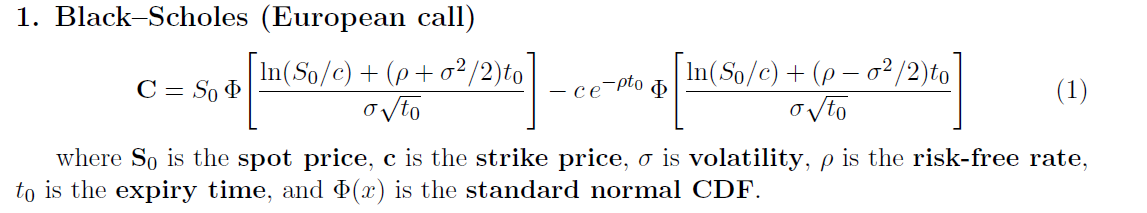

Call Option

Put Option

In [1]:
1+1

2